In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Stroke

In [104]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [105]:
df['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [106]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [107]:
df['gender']

0         Male
1       Female
2         Male
3       Female
4       Female
         ...  
5105    Female
5106    Female
5107    Female
5108      Male
5109    Female
Name: gender, Length: 5110, dtype: object

In [108]:
df = df[df['gender']!='Other']
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0}).astype(int)
df['ever_married'] = df['ever_married'].replace({'Yes': 1, 'No': 0}).astype(int)
df['Residence_type'] = df['Residence_type'].replace({'Urban': 1, 'Rural': 0}).astype(int)
df['smoking_status'] = df['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': np.nan}).astype(float)
df = df.drop(columns=['id'])

In [109]:
df = pd.get_dummies(df)

df_boolean = df.select_dtypes(include=['bool']).columns
df[df_boolean] = df[df_boolean].astype(bool).astype(int)

In [110]:
df.dtypes

gender                       int32
age                        float64
hypertension                 int64
heart_disease                int64
ever_married                 int32
Residence_type               int32
avg_glucose_level          float64
bmi                        float64
smoking_status             float64
stroke                       int64
work_type_Govt_job           int32
work_type_Never_worked       int32
work_type_Private            int32
work_type_Self-employed      int32
work_type_children           int32
dtype: object

In [111]:
df.duplicated().sum()

0

In [112]:
df.shape

(5109, 15)

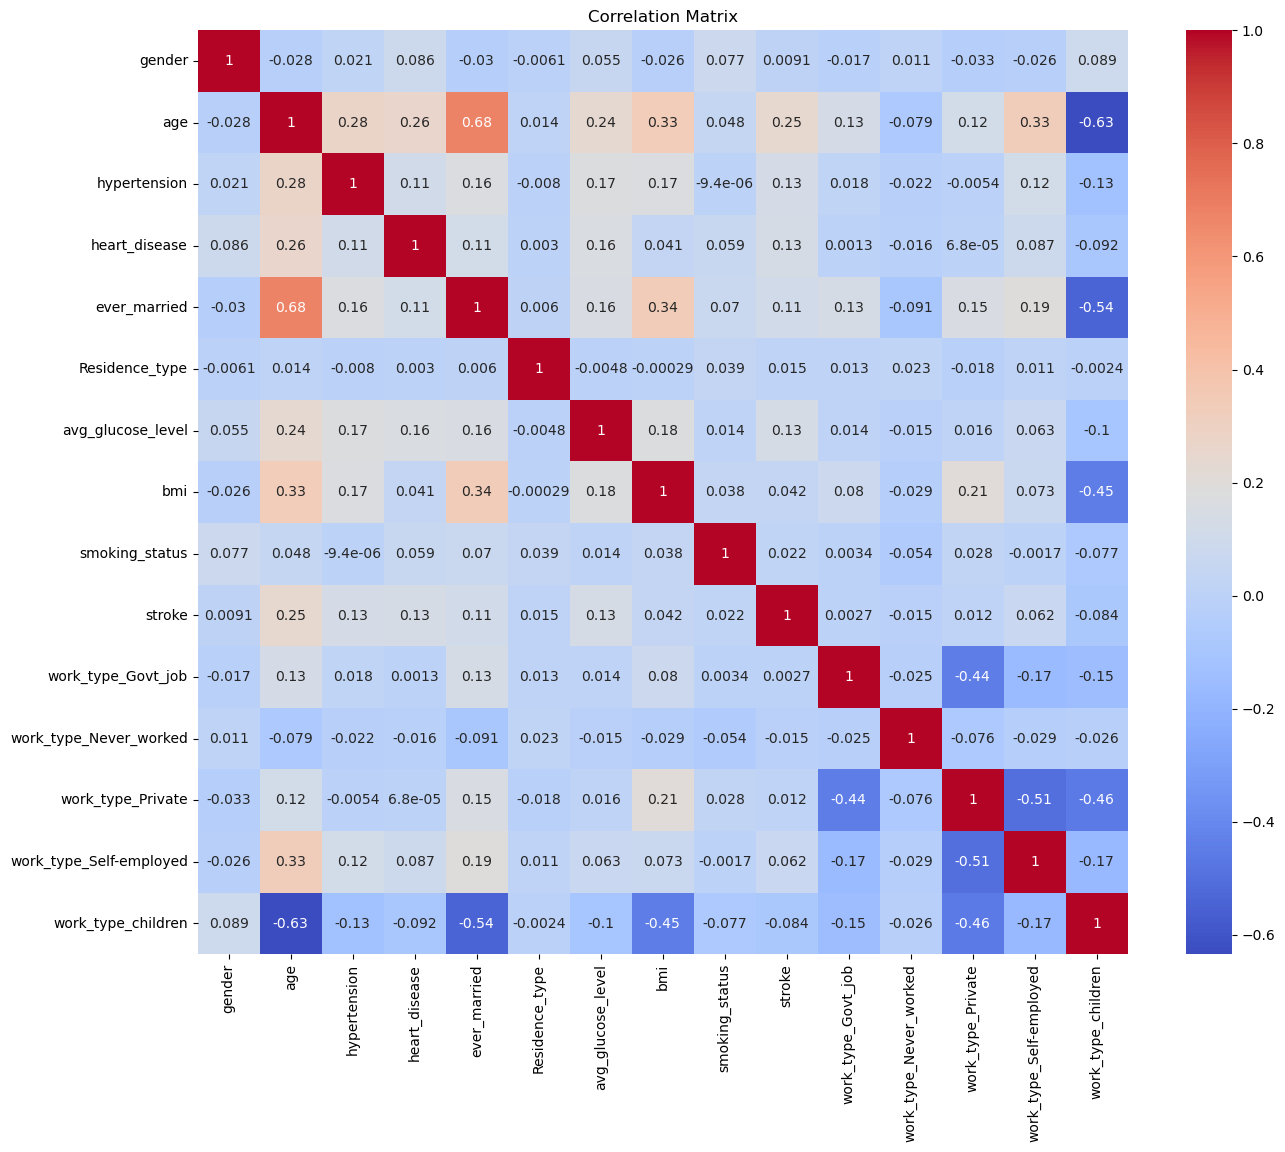

In [113]:
df = df.select_dtypes("number")
plt.figure(figsize=(15,12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [114]:
from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento y prueba
X = df.drop(columns=['stroke'])  # Variables independientes
y = df['stroke']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear el modelo
model = DecisionTreeClassifier()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9080234833659491
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       968
           1       0.16      0.17      0.16        54

    accuracy                           0.91      1022
   macro avg       0.55      0.56      0.56      1022
weighted avg       0.91      0.91      0.91      1022



In [122]:
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor


# Dividir en conjunto de entrenamiento y prueba
df = df.dropna()
X = df.drop(columns=['bmi'])  # Variables independientes
y = df['bmi'] # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Crear el modelo de Random Forest
model = RandomForestRegressor()
# Crear el modelo de regresión con árboles de decisión
#model = DecisionTreeRegressor()
# Crear el modelo
#model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error (MSE): 54.211384538686126
R² Score: -0.015092221348057988


In [ ]:
'''from sklearn.metrics import confusion_matrix
import numpy as np

def mostrarResultados(tasa_acierto_train, perdida_train, tasa_acierto_test, perdida_test, tiempo_entrenamiento, y_test, y_pred):
    print("Tasa de acierto (entrenamiento): {:.2f}%".format(tasa_acierto_train * 100))
    print("Tasa de pérdida (entrenamiento): {:.4f}%".format(perdida_train * 100))
    print("Tiempo de entrenamiento: {:.2f} segundos".format(tiempo_entrenamiento))
    print("Tasa de acierto (test): {:.2f}%".format(tasa_acierto_test * 100))
    print("Tasa de pérdida (test): {:.4f}%".format(perdida_test * 100))   
    calcularMatrizConfusion(y_test, y_pred)

# Calcula y muestra una matriz de confusión utilizando Seaborn
def calcularMatrizConfusion(y_test, y_pred):    
    y_pred_class = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(1,figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show  '''